In [1]:
%matplotlib inline
import json
import tabulate
import datetime
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def int2dur(x):
    minutes = int(x // 60)
    seconds = int(round(x - minutes * 60))
    return f"{minutes: 3d}m{seconds:02d}s"

class CPDF_Point:
    """
    spread out the cdf-ness. Starts at `point-spread/2` and ends at `point+spread/2`
    """
    def __init__(self, point, spread):
        self.point = point
        self.spread = spread
        self.lo = point - spread / 2.0
        self.hi = point + spread / 2.0
        self.type = "COSINE"
    
    def cdf(self, x):
        frac = (x - self.lo) / self.spread
        if x < self.lo:
            return 0.0
        elif x > self.hi:
            return 1.0
        elif self.type == "LINEAR":
            return frac
        elif self.type == "COSINE":
            # f(x) = (1-cos( frac * pi )) / 2.0
            return (1 - np.cos( frac * np.pi)) / 2.0
    
    def pdf(self, x):

        if x < self.lo:
            return 0.0
        elif x > self.hi:
            return 0.0
        elif self.type == "LINEAR":
            return 1.0 / self.spread
        elif self.type == "COSINE":
            return np.pi * np.sin(np.pi * (self.lo - x) / (self.lo - self.hi))/ (2 * (self.hi - self.lo))
        
        
class CPDF:
    def __init__(self, points, spread):
        self.points = [CPDF_Point(_, spread) for _ in points]

    def eval_cdf_at(self, x):
        scale = len(self.points)
        return sum(_.cdf(x) for _ in self.points) / scale
        
    def eval_pdf_at(self, x):
        scale = len(self.points)
        return sum(_.pdf(x) for _ in self.points) / scale


def make_cdf(x):
    cdf_x = [0.0]
    cdf_y = [0.0]
    for idx, val in enumerate(x):
        cdf_x.append(val / 60.0)
        cdf_y.append(cdf_y[-1])
        
        cdf_x.append(val / 60.0)
        cdf_y.append((1 + idx) / len(x))
    return [cdf_x, cdf_y]

def analyze_speakers(data, title="", _filter=None):

    if _filter is not None:
        new_data = [_ for _ in data if _filter(_)]
    else:
        new_data = [_ for _ in data]
    speakers = [_ for sublist in new_data for _ in sublist["speakers"]]
    
    if title != "":
        print(f"\n=====[ Analyzing '{title}' ]=====\n")

        
    N_first_female = sum([1 for _ in new_data if _["speakers"][0]["sex"] == "female"])
    N_first_male = sum([1 for _ in new_data if _["speakers"][0]["sex"] == "male"])

    N_last_female = sum([1 for _ in new_data if _["speakers"][-1]["sex"] == "female"])
    N_last_male = sum([1 for _ in new_data if _["speakers"][-1]["sex"] == "male"])
    
    
    sex = [_["sex"] for _ in speakers]
    duration = [_["duration"] for _ in speakers]

    total_duration = sum(duration)
    female_durations = list(sorted([_["duration"] for _ in speakers if _["sex"] == "female"]))
    male_durations = list(sorted([_["duration"] for _ in speakers if _["sex"] == "male"]))
    
    table = {
        "sex": ["female", "male"],
        "N": [len(female_durations), len(male_durations)],
        "N first": [N_first_female, N_first_male],
        "N last": [N_last_female, N_last_male],
        "total": [int2dur(sum(female_durations)), int2dur(sum(male_durations))],
        "percent": [sum(female_durations)/total_duration*100, sum(male_durations)/total_duration*100],
        "min": [int2dur(min(female_durations)), int2dur(min(male_durations))],
        "mean": [int2dur(np.mean(female_durations)), int2dur(np.mean(male_durations))],
        "max": [int2dur(max(female_durations)), int2dur(max(male_durations))],
    }
    
    print(tabulate.tabulate(table, headers="keys"))
    
    k = len(female_durations)
    n = len(speakers)
    alpha = 0.05  # 95% confidence
    p_u, p_o = beta.ppf([alpha/2, 1 - alpha/2], [k, k + 1], [n - k + 1, n-k])
    print(f"The observed rate of females speaking is {k / n * 100:.2f}%")
    print(f"I am 95% confident that the true rate is between {p_u*100:.2f}% and {p_o * 100:.2f}%")
    #print("female stats", p_u, k / n, p_o)
    
    cpdf_female = CPDF(female_durations, 60.0)
    cpdf_male = CPDF(male_durations, 60.0)
    x = np.linspace(0.0, 30.0 * 60.0, 500)
    x_minutes = [_ / 60.0 for _ in x]
    cdf_female = [cpdf_female.eval_cdf_at(_) for _ in x]
    cdf_male = [cpdf_male.eval_cdf_at(_) for _ in x]
    pdf_female = [cpdf_female.eval_pdf_at(_) for _ in x]
    pdf_male = [cpdf_male.eval_pdf_at(_) for _ in x]
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle(title)
    ax1.plot(x_minutes, cdf_female, c="m", label="female")
    ax1.plot(x_minutes, cdf_male, c="c", label="male")

    ax2.plot(x_minutes, pdf_female, c="m")
    ax2.plot(x_minutes, pdf_male, c="c")
    
    fig.legend()
    #fig.show()

In [2]:
with open("data.json", "r") as stream:
    data = json.load(stream)
    
for idx in range(len(data)):
    print(f"Processing {data[idx]['date']}")
    data[idx]["date"] = datetime.datetime.strptime(data[idx]["date"], "%Y-%m-%d").date()
    for jdx in range(len(data[idx]["speakers"])):
        duration_txt = data[idx]["speakers"][jdx]["duration"]
        minutes, seconds = duration_txt.split(":")
        data[idx]["speakers"][jdx]["duration"] = int(minutes) * 60 + int(seconds)
    
print(f"Found {len(data)} meetings")
meeting_types = set([_["meeting"] for _ in data])
meeting_types

Processing 2023-05-28
Processing 2023-06-04
Processing 2023-06-11
Processing 2023-06-25
Processing 2023-07-02
Processing 2023-07-09
Processing 2023-07-16
Processing 2023-07-23
Found 8 meetings


{'fast sunday', 'regular'}


=====[ Analyzing 'all speakers' ]=====

sex       N    N first    N last  total      percent  min    mean    max
------  ---  ---------  --------  -------  ---------  -----  ------  ------
female   25          4         3  113m44s     46.343  0m12s  4m33s   17m22s
male     20          4         5  131m41s     53.657  0m16s  6m35s   22m40s
The observed rate of females speaking is 55.56%
I am 95% confident that the true rate is between 40.00% and 70.36%

=====[ Analyzing 'regular' ]=====

sex       N    N first    N last  total      percent  min    mean    max
------  ---  ---------  --------  -------  ---------  -----  ------  ------
female    7          4         1  76m35s     41.7613  1m09s  10m56s  17m22s
male     11          2         5  106m48s    58.2387  1m23s  9m43s   22m40s
The observed rate of females speaking is 38.89%
I am 95% confident that the true rate is between 17.30% and 64.25%

=====[ Analyzing 'fast sunday' ]=====

sex       N    N first    N last  total      percen

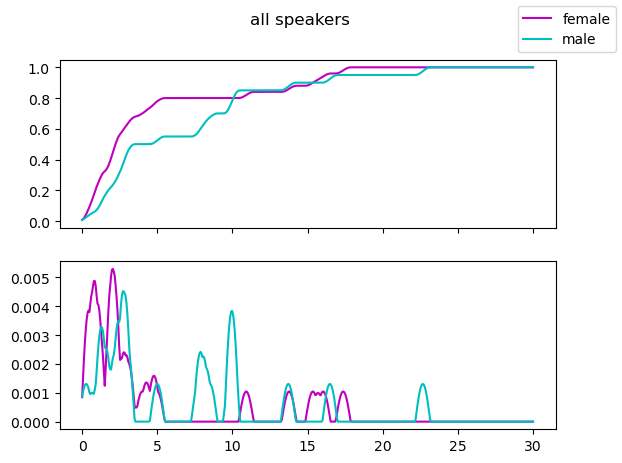

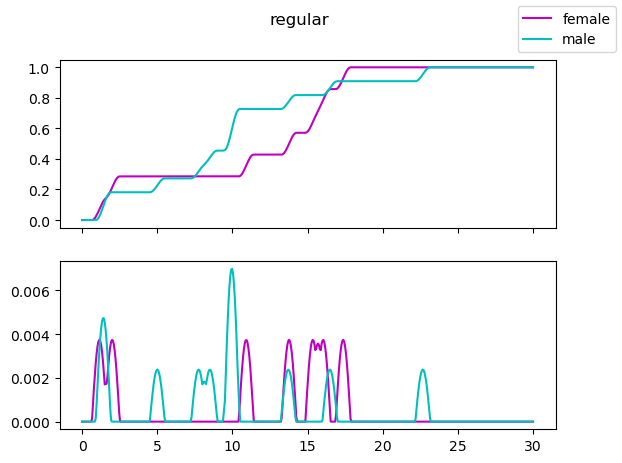

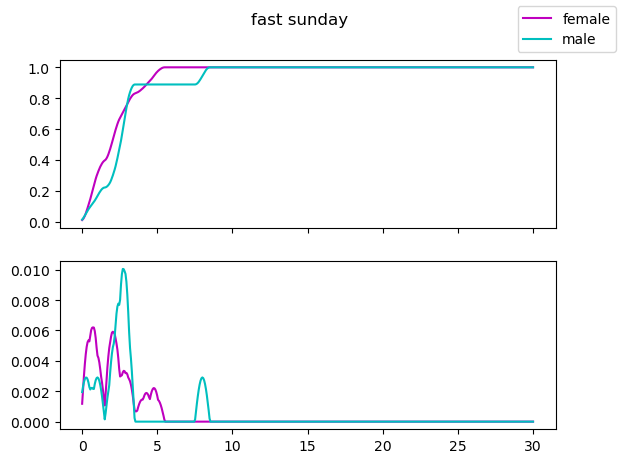

In [3]:
analyze_speakers(data, title="all speakers")

for meeting_type in meeting_types:
    analyze_speakers(data, title=meeting_type, _filter=lambda x: x["meeting"] == meeting_type)